# T5-Summarizer

## Import and Install required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/NLP

/content/drive/MyDrive/NLP


In [3]:
ls -l

total 2613422
drwx------ 2 root root       4096 Apr 23 08:48  archive/
-rw------- 1 root root 2675123114 Apr 22 14:03 'epoch=1-step=26668.ckpt'
-rw------- 1 root root    1016514 Apr 23 15:53  T5_summarizer.ipynb


In [4]:
!pip install pytorch_lightning
!pip install nltk
!pip install spacy
!pip install evaluate
!pip install transformers
!pip install wordcloud
!pip install sentencepiece
!pip install tensorflow
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 32.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-man

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=a581134d2aff59d23cf576d6c7d3c810afa69b4bdb49d8e70261eb207e785759
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [5]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.11.0 which is incompatible.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler  # Import classes for handling datasets and data loading
import pytorch_lightning as pl  # Import PyTorch Lightning for training and logging
import nltk  # Natural Language Toolkit for text processing
from nltk.corpus import stopwords  # Stopwords for text preprocessing
nltk.download('stopwords')  # Download NLTK stopwords data
from nltk.stem import WordNetLemmatizer  # Lemmatization for text preprocessing
nltk.download("wordnet")  # Download NLTK WordNet data
nltk.download('omw-1.4')  # Download NLTK Open Multilingual WordNet data
import os  # Operating system interface for file handling
import string  # String operations for text preprocessing
import pandas as pd  # Pandas for data manipulation and analysis
import numpy as np  # NumPy for numerical computations
import evaluate
import matplotlib.pyplot as plt  # Matplotlib for plotting
import transformers  # Hugging Face Transformers library for pre-trained models
from transformers import T5ForConditionalGeneration, T5Tokenizer  # Import T5 model and tokenizer
from transformers import get_linear_schedule_with_warmup, AdamW  # Optimizer and scheduler for training
from sklearn.model_selection import train_test_split  # Splitting data into train and validation sets
import matplotlib.pyplot as plt  # Matplotlib for plotting
import warnings  # Suppress warnings during execution
from wordcloud import WordCloud
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow_hub as hub
import tensorflow_text as text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [7]:
# Ignore warnings
warnings.filterwarnings("ignore")

## Unzip the dataset

In [8]:
ls -l

total 2613308
drwx------ 2 root root       4096 Apr 23 08:48  archive/
-rw------- 1 root root 2675123114 Apr 22 14:03 'epoch=1-step=26668.ckpt'
-rw------- 1 root root     899259 Apr 23 15:58  T5_summarizer.ipynb


In [ ]:
!unzip archive.zip

## Read Data (Amazon Reviews)

The code segment performs data preprocessing and analysis tasks on a dataset extracted from 'Reviews.csv'. Initially, it sets the total number of samples to 100,000. The data is loaded into a Pandas DataFrame ('df') from the specified CSV file, and preprocessing steps include removing duplicate rows based on the 'Text' column and dropping rows with missing values in the 'Summary' column. The code then calculates the distribution of scores in the dataset and determines the number of examples to sample for each score category. Using this information, it samples exactly the required number of examples for each score, storing them in a list and concatenating them into a single DataFrame ('selected_df'). Finally, it extracts the relevant columns ('Text', 'Summary', 'Score') from the concatenated DataFrame for further analysis. This preprocessing is crucial for creating a balanced dataset suitable for training and evaluation

In [9]:
# Set the total number of samples
total_number_of_samples = 100000

# Load data from Reviews.csv and preprocess it
df = pd.read_csv('./archive/Reviews.csv')  # Load data from the Reviews.csv file
df.drop_duplicates(subset=['Text'], inplace=True)  # Drop duplicate rows based on 'Text' column
df.dropna(subset=['Summary'], inplace=True)  # Drop rows with missing values in the 'Summary' column

# Count score distribution
score_distribution = df['Score'].value_counts().sort_index()  # Count the distribution of scores and sort by score value
total_examples_per_score = total_number_of_samples // len(score_distribution)  # Calculate the number of examples per score

# Sample exactly the determined number of examples for each score
selected_examples = []  # Initialize a list to store selected examples for each score
for score, count in score_distribution.items():  # Iterate over score distribution
    examples = df[df['Score'] == score].sample(n=total_examples_per_score)  # Sample examples for each score
    selected_examples.append(examples)  # Append selected examples to the list

# Concatenate the selected examples into a single dataframe
selected_df = pd.concat(selected_examples)

# Extract relevant columns
data = selected_df[['Text', 'Summary', 'Score']]  # Extract 'Text', 'Summary', and 'Score' columns from selected dataframe

## Visualize some statistics

This code segment performs visualizations using matplotlib to analyze the distribution of reviews per score, as well as the lengths of the text and summary fields in the dataset. It generates two histograms, one for the distribution of review scores and another for the lengths of the text and summary fields

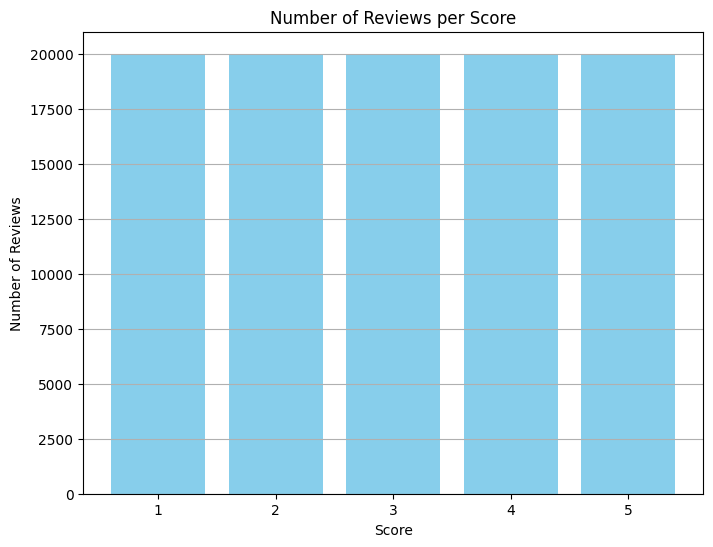

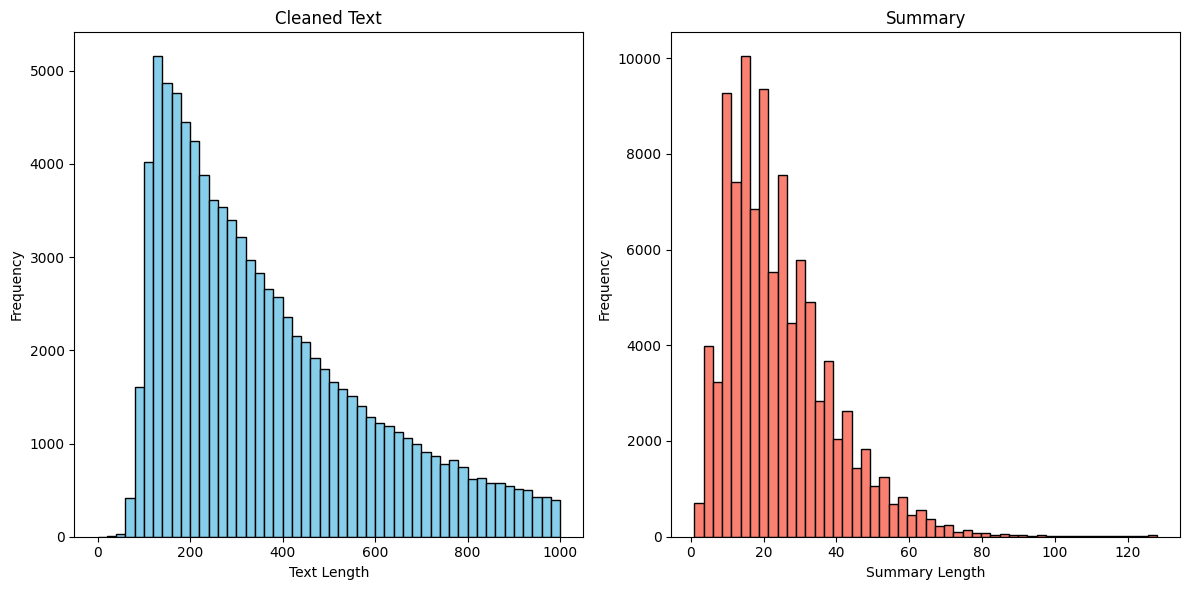

In [10]:
# Count the number of reviews per score
score_counts = data['Score'].value_counts().sort_index()

# Plot the histogram for score distribution
plt.figure(figsize=(8, 6))  # Create a new figure with a specific size
plt.bar(score_counts.index, score_counts.values, color='skyblue')  # Create a bar plot for score counts
plt.xlabel('Score')  # Set the x-axis label
plt.ylabel('Number of Reviews')  # Set the y-axis label
plt.title('Number of Reviews per Score')  # Set the plot title
plt.xticks(score_counts.index)  # Set the x-axis ticks to match score values
plt.grid(axis='y')  # Add a grid to the plot along the y-axis
plt.show()  # Show the plot

# Calculate text and summary lengths
text_length = data['Text'].apply(len)  # Calculate the length of each text
summary_length = data['Summary'].apply(len)  # Calculate the length of each summary

# Create a figure and two subplots for histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots in a 1x2 grid

# Plot histogram for text length in the first subplot
axs[0].hist(text_length, bins=50, range=(0, 1000), color='skyblue', edgecolor='black')  # Plot histogram for text length
axs[0].set_xlabel('Text Length')  # Set the x-axis label for the first subplot
axs[0].set_ylabel('Frequency')  # Set the y-axis label for the first subplot
axs[0].set_title('Cleaned Text')  # Set the title for the first subplot

# Plot histogram for summary length in the second subplot
axs[1].hist(summary_length, bins=50, color='salmon', edgecolor='black')  # Plot histogram for summary length
axs[1].set_xlabel('Summary Length')  # Set the x-axis label for the second subplot
axs[1].set_ylabel('Frequency')  # Set the y-axis label for the second subplot
axs[1].set_title('Summary')  # Set the title for the second subplot

# Adjust layout for better visualization
plt.tight_layout()  # Automatically adjust subplot parameters to fit into the figure area

# Show the plots
plt.show()

## Visualize word clouds

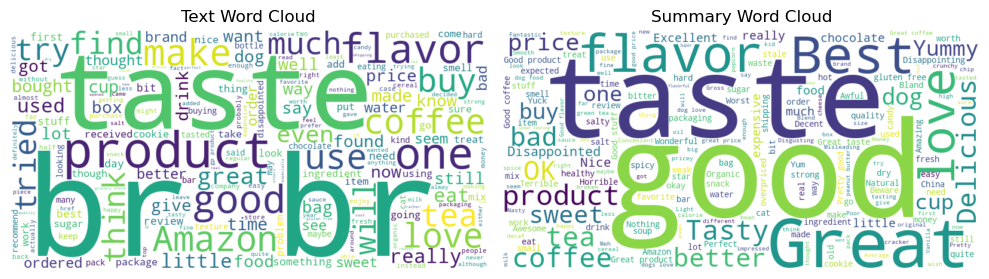

In [ ]:
# Create WordCloud objects for 'Text' and 'Summary' columns
text_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['Text']))
summary_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['Summary']))

# Plot the word clouds for 'Text' and 'Summary'
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Subplot for 'Text' word cloud
plt.imshow(text_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Text Word Cloud')

plt.subplot(1, 2, 2)  # Subplot for 'Summary' word cloud
plt.imshow(summary_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Summary Word Cloud')

plt.tight_layout()
plt.show()

## Split Dataset into train, test and validation datasets

In [11]:
# Split the data into training, validation, and test sets
# Using train_test_split from scikit-learn
# Splitting first into training and test sets
train_df, test_df = train_test_split(data, test_size=0.2, shuffle=True, stratify=data['Score'], random_state=42)
# Further splitting the test set into test and validation sets
test_df, val_df = train_test_split(test_df, test_size=0.5, shuffle=True, stratify=test_df['Score'], random_state=42)

# Reset index for the dataframes to ensure consistency and avoid issues
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

## Define Important Constants and pre trained model

The constants and settings defined for the model and training process are crucial for ensuring efficient and effective training of the T5 model. The T5 model is loaded using the 't5-base' pretrained weights. The corresponding tokenizer is instantiated as 'TOKENIZER'. A batch size of 6 samples is chosen for training efficiency, balancing computational resources and training stability. Additionally, we configured the maximum input lengths of 256 tokens for text and 32 tokens for headline summaries ('TEXT_LEN' and 'HEADLINE_LEN', respectively). These values are set to manage data preprocessing and model input constraints. Finally, The training process is scheduled to run for 2 epochs ('EPOCHS').

It is important to note that this algorithm has been fine tuned making use of our GPU to speed up the training process

The T5 (Text-to-Text Transfer Transformer) model is a transformer-based architecture developed by Google. It is a versatile model designed for various natural language processing (NLP) tasks, including text generation, translation, summarization, question answering, and more. The key idea behind the T5 model is to treat all NLP tasks as text-to-text tasks, where both the input and output are represented as text sequences.

The architecture of the T5 model follows the Transformer architecture, which includes multi-head self-attention mechanisms and feed-forward neural networks. T5 is trained on a diverse set of text-to-text tasks using a unified objective function. The T5 model's training objective is called the Text-to-Text Transfer Transformer (T5) objective, where the model is trained to convert a given input text into a target output text. This objective allows T5 to perform a wide range of NLP tasks by framing them as text-to-text transformations. T5 paper (https://arxiv.org/pdf/1910.10683v4.pdf)

![Example Image](https://www.researchgate.net/publication/371619795/figure/fig2/AS:11431281168463909@1686969039930/Architecture-of-the-T5-model.ppm)

In [12]:
# Define constants and settings for the model and training

# Load the T5 model for conditional generation
MODEL = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
# Load the T5 tokenizer
TOKENIZER = T5Tokenizer.from_pretrained("t5-base")

# Define batch size for training
BATCH_SIZE = 6

# Maximum length for input text and headline summaries
TEXT_LEN = 256  # Maximum length for input text
HEADLINE_LEN = 32  # Maximum length for headline summaries

# Number of epochs for training
EPOCHS = 2

# Select device for training (GPU if available, otherwise CPU)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Create Dataloader class

The custom dataset class SummaryDataset is designed for the summarization tasks. Its purpose is to facilitate the preprocessing and organization of data, which must be stored in a dataframe containing text and summary columns. In the class's initialization method, we set up the dataFrame containing the texts, the tokenizer responsible for text tokenization, and parameters defining the maximum lengths allowed for input text and summaries. The __len__ method calculates and returns the total number of samples in the dataset, determined by the length of the 'Summary' column. The __getitem__ method retrieves individual samples from the dataset based on its index, applies necessary preprocessing steps such as adding the "summarize:" prefix to input text for T5 summarization, tokenizes both the text and summmary using the specified tokenizer, and constructs a dictionary format containing input IDs, attention masks (binary masks that indicate which tokens in the input sequence should be attended), summary IDs, and summary masks. These processed texts will be feeding into the T5 model during training.

In [13]:
# Define a custom dataset class for summarization
class SummaryDataset(Dataset):
    def __init__(self, df, tokenizer, text_len, headline_len):
        # Initialize the dataset
        self.df = df  # DataFrame containing text and summary columns
        self.headlines = self.df["Summary"]  # Extract summary column
        self.text = self.df["Text"]  # Extract text column
        self.tokenizer = tokenizer  # Tokenizer for text preprocessing
        self.text_len = text_len  # Maximum length for input text
        self.headline_len = headline_len  # Maximum length for headline summaries

    def __len__(self):
        # Get the total number of samples in the dataset
        return len(self.headlines)

    def __getitem__(self, idx):
        # Get a single item (sample) from the dataset at index 'idx'
        text = "summarize:" + str(self.text[idx])  # Add prefix for T5 summarization
        headline = str(self.headlines[idx])  # Get the headline summary for the sample

        # Tokenize the text and headline using the tokenizer
        text_tokenizer = self.tokenizer(text, max_length=self.text_len, padding="max_length",
                                        truncation=True, add_special_tokens=True)
        headline_tokenizer = self.tokenizer(headline, max_length=self.headline_len, padding="max_length",
                                            truncation=True, add_special_tokens=True)

        # Return the tokenized inputs and outputs as a dictionary
        return {
            "input_ids": torch.tensor(text_tokenizer["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(text_tokenizer["attention_mask"], dtype=torch.long),
            "summary_ids": torch.tensor(headline_tokenizer["input_ids"], dtype=torch.long),
            "summary_mask": torch.tensor(headline_tokenizer["attention_mask"], dtype=torch.long)
        }

The custom Lightning DataModule named SummaryDataModule is designed to streamline the data handling process for training, validation, and testing phases. It takes as input training, validation, and test dataframes, along with parameters such as batch size, tokenizer, and maximum lengths for input text and summary. The initialization process sets up the necessary components for data management within the module. During the setup phase, datasets for training, validation, and testing are prepared using the SummaryDataset class, which encapsulates data preprocessing and tokenization as it was explained before. The module provides DataLoader objects (train_dataloader, val_dataloader, and test_dataloader) configured with batch size, shuffling, and parallel data loading settings, enhancing efficiency and scalability during training and evaluation.

In [14]:
# Define a custom Lightning DataModule for training, validation, and testing
class SummaryDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, batch_size, tokenizer, text_len, summary_len):
        super().__init__()
        # Initialize the data module with training, validation, and test dataframes, batch size,
        # tokenizer, maximum lengths for input text and summary, and setup datasets
        self.train_df = train_df  # DataFrame for training data
        self.val_df = val_df  # DataFrame for validation data
        self.test_df = test_df  # DataFrame for test data
        self.batch_size = batch_size  # Batch size for DataLoader
        self.tokenizer = tokenizer  # Tokenizer for text preprocessing
        self.text_len = text_len  # Maximum length for input text
        self.summary_len = summary_len  # Maximum length for summary

    def setup(self, stage=None):
        # Setup datasets for training, validation, and testing using the SummaryDataset class
        self.train_dataset = SummaryDataset(self.train_df, self.tokenizer, self.text_len, self.summary_len)
        self.val_dataset = SummaryDataset(self.val_df, self.tokenizer, self.text_len, self.summary_len)
        self.test_dataset = SummaryDataset(self.test_df, self.tokenizer, self.text_len, self.summary_len)

    def train_dataloader(self):
        # Return a DataLoader for the training dataset
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        # Return a DataLoader for the validation dataset
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        # Return a DataLoader for the test dataset
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)

In [15]:
# Initialize the Lightning DataModule
summary_module = SummaryDataModule(train_df, val_df, test_df, BATCH_SIZE, TOKENIZER, TEXT_LEN, HEADLINE_LEN)

# Setup the Lightning DataModule
summary_module.setup()

## Create Summary Model Class

This class is created specifically for the task of summarization within the PyTorch Lightning framework. This model is the main part of the summarization algorithm, because it implements the process of taking input sequences and generate corresponding summaries (forward method). This method organizes the model's forward pass, handling input IDs, attention masks, labels, and decoder attention masks. For this process the outputs are the loss and logits (raw predictions).

For training, the training_step method defines the steps taken during each iteration of the training process. It receives batches of data, extracts relevant information such as input IDs, attention masks, labels, and decoder attention masks, and performs a forward pass through the model. The computed loss returned to optimize the model during the training phase. Similarly, the validation_step mirrors the training step by processing batches of validation data, calculating the loss, and returning it for evaluation purposes.

Lastly, the configure_optimizers method configure the optimizer and scheduler for the training process. In this methos the AdamW optimizer with a learning rate of 0.0001 is configured, along with a linear scheduler with warmup steps, contributing to the model's effective training process.

In [16]:
# Define a custom LightningModule for summarization
class SummaryModel(pl.LightningModule):
    def __init__(self):
        super(SummaryModel, self).__init__()
        self.model = MODEL  # Initialize the T5 model for summarization

    def forward(self, input_ids, attention_mask, labels=None, decoder_attention_mask=None):
        # Forward pass through the model
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels,
                             decoder_attention_mask=decoder_attention_mask)
        return outputs.loss, outputs.logits  # Return loss and logits from model output

    def training_step(self, batch, batch_idx):
        # Training step
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["summary_ids"]
        decoder_attention_mask = batch["summary_mask"]

        loss, output = self(input_ids, attention_mask, labels, decoder_attention_mask)
        return loss  # Return loss for optimization during training

    def validation_step(self, batch, batch_idx):
        # Validation step
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["summary_ids"]
        decoder_attention_mask = batch["summary_mask"]

        loss, output = self(input_ids, attention_mask, labels, decoder_attention_mask)
        return loss  # Return loss for evaluation during validation

    def test_step(self, batch, batch_idx):
        # Test step
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        loss, output = self(input_ids=input_ids, attention_mask=attention_mask)
        return loss  # Return loss for evaluation during testing

    def configure_optimizers(self):
        # Configure optimizer and scheduler
        optimizer = AdamW(self.model.parameters(), lr=0.0001)  # AdamW optimizer with a learning rate of 0.0001
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                    num_training_steps=EPOCHS * len(df))  # Scheduler for optimizer
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}  # Return optimizer and scheduler for training


## Start Training Process

In [ ]:
# Initialize the model
model = SummaryModel()  # Create an instance of the custom SummaryModel for summarization

# Define the Lightning Trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,  # Set the maximum number of epochs for training
    accelerator="gpu"  # Use GPU for acceleration if available
)

# Train the model
trainer.fit(model, summary_module)  # Fit the model using the specified Trainer and SummaryDataModule

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/nlp/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 13334/13334 [1:15:09<00:00,  2.96it/s, v_num=0]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13334/13334 [1:15:09<00:00,  2.96it/s, v_num=0]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13334/13334 [1:18:02<00:00,  2.85it/s, v_num=0]   

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 13334/13334 [1:18:31<00:00,  2.83it/s, v_num=0]


## Test the trained model

The following function tokenizes input text using the specified tokenizer and then processes it through the summarization model to generate the final summary. The tokenization parameters, such as maximum length and padding, ensure the input is formatted appropriately for the model. The model's generate method, produces token IDs representing the summary. These token IDs are then decoded back into human-readable text, excluding special tokens, resulting in a coherent summary text.

In [17]:
# Define a function for summarization
def summarize(text, DEVICE):
    # Tokenize the input text using the tokenizer
    inputs = TOKENIZER(text, max_length=TEXT_LEN, truncation=True, padding="max_length",
                       add_special_tokens=True, return_tensors="pt")

    # Generate the summarized output using the model
    summarized_ids = summary_model.model.generate(input_ids=inputs["input_ids"].to(DEVICE),
                                                  attention_mask=inputs["attention_mask"].to(DEVICE),
                                                  num_beams=4)

    # Decode the token IDs to obtain the summarized text
    return " ".join([TOKENIZER.decode(token_ids, skip_special_tokens=True) for token_ids in summarized_ids])

### Test on testing dataset using word embeddings and cosine similarity as a performance metric

In [18]:
ls -l

total 2613309
drwx------ 2 root root       4096 Apr 23 08:48  archive/
-rw------- 1 root root 2675123114 Apr 22 14:03 'epoch=1-step=26668.ckpt'
-rw------- 1 root root     900751 Apr 23 15:59  T5_summarizer.ipynb


This code defines two dictionaries, **map_name_to_handle** and **map_model_to_preprocess**, which map model names to their corresponding URLs for TensorFlow Hub models and preprocessors, respectively. These dictionaries are used to select the appropriate URLs based on the specified bert_model_name.

In [19]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [20]:
# Import necessary libraries
import os  # For operating system functionalities
import shutil  # For file and directory operations

import tensorflow as tf  # TensorFlow library
import tensorflow_hub as hub  # TensorFlow Hub for pre-trained models
import tensorflow_text as text  # TensorFlow Text for text processing
from official.nlp import optimization  # Official TensorFlow NLP library for optimization

import matplotlib.pyplot as plt  # Matplotlib for plotting

# Set TensorFlow logger level to ERROR to suppress unnecessary messages
tf.get_logger().setLevel('ERROR')


In [21]:
# Load the BERT model from TensorFlow Hub using its handle
bert_model = hub.KerasLayer(tfhub_handle_encoder)

# Load the BERT preprocessor model from TensorFlow Hub using its handle
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In this code, the similarity between original texts, their summaries, and ground truth summaries is calculated. The process begins by defining a function compare_cosine_similarity that leverages BERT embeddings to compute cosine similarity scores between pairs of texts. The previously trained summary model (T5) is loaded and used to generate summaries for the original texts. These generated summaries are then compared with both the original texts and the ground truth summaries using the cosine similarity metric. Finally, the average cosine similarity scores are calculated and printed to assess the quality of the summarization process in relation to the original texts and the ground truth summaries.

In [ ]:


# Define a function to compare cosine similarity between two texts
def compare_cosine_similarity(text1, text2):
    # Preprocess text 1 using the BERT preprocessor model
    text_preprocessed_1 = bert_preprocess_model([text1])
    bert_results_1 = bert_model(text_preprocessed_1)  # Get BERT embeddings for text 1

    # Preprocess text 2 using the BERT preprocessor model
    text_preprocessed_2 = bert_preprocess_model([text2])
    bert_results_2 = bert_model(text_preprocessed_2)  # Get BERT embeddings for text 2

    # Extract BERT embeddings
    bert_embeddings_1 = bert_results_1["pooled_output"]
    bert_embeddings_2 = bert_results_2["pooled_output"]

    # Calculate the cosine similarity between the BERT embeddings
    similarity_score = cosine_similarity(bert_embeddings_1, bert_embeddings_2)[0][0]
    return similarity_score  # Return the cosine similarity score

# Load the best checkpoint for evaluation
summary_model = SummaryModel.load_from_checkpoint('epoch=1-step=26668.ckpt')
summary_model.freeze()  # Freeze the model parameters

similarity = []  # Initialize a list to store similarity scores
similarity_summary = []

# Iterate over the test dataset to compute similarity scores
for i in range(len(test_df)):
    text = test_df.iloc[i]["Text"]  # Get the text from the test dataset
    summary_gt = test_df.iloc[i]["Summary"]
    summarized_text = summarize(text, DEVICE)  # Generate a summary for the text using a summarization function

    # Compute and store the cosine similarity between the original text and its summary
    try:
        similarity.append(compare_cosine_similarity(text, summarized_text))
        similarity_summary.append(compare_cosine_similarity(summary_gt, summarized_text))
    except:
        print('error')
        pass  # Handle any exceptions that may occur during computation

# Calculate the average similarity score
average1 = sum(similarity) / len(similarity)
average2 = sum(similarity_summary) / len(similarity_summary)

print(f'The cosine similarity with the text is {average1}')
print(f'The cosine similarity with the summary is {average2}')

progress: 0.5%, similarity score with original text: 0.7583658885955811, similarity score with summary: 0.7963721549510956
progress: 1.0%, similarity score with original text: 0.7704415541887283, similarity score with summary: 0.7876934033632278
progress: 1.5%, similarity score with original text: 0.7718173031012218, similarity score with summary: 0.7925521123409272
progress: 2.0%, similarity score with original text: 0.7768907406926155, similarity score with summary: 0.7948446929454803
progress: 2.5%, similarity score with original text: 0.7828256537914277, similarity score with summary: 0.7977580811977386
progress: 3.0%, similarity score with original text: 0.7830271649360657, similarity score with summary: 0.7979245873292288
progress: 3.5%, similarity score with original text: 0.7826840780462537, similarity score with summary: 0.797529650415693
progress: 4.0%, similarity score with original text: 0.7856690683960914, similarity score with summary: 0.7972372734546661
progress: 4.5%, s

## Show prediction Examples

In [25]:
# Load the best checkpoint for evaluation
summary_model = SummaryModel.load_from_checkpoint('epoch=1-step=26668.ckpt')
summary_model.freeze()  # Freeze the model parameters
# Iterate over the test dataset to compute similarity scores
for i in range(20):
    text = test_df.iloc[i]["Text"]  # Get the text from the test dataset
    summary_gt = test_df.iloc[i]["Summary"]
    summarized_text = summarize(text, DEVICE)  # Generate a summary for the text using a summarization function

    print(f'Original Text: {text}')
    print('')
    print(f'Summary Ground Truth: {summary_gt}')
    print('')
    print(f'Predicted summary: {summarized_text}')
    print('-------------------------------------------------------------------------')

Original Text: Shopping in one of those big warehouse club stores is an interesting experience. You wander around with this huge shopping cart looking at piles of stuff that you otherwise wouldn't be looking for and all of a sudden another impulse item goes into the cart. Take the other day, for example. We wandered down a food isle and there sat a palette of Kirkland Signature 100% Pure Maple Syrup. Well, we eat pancakes now and then, but we don't use maple syrup. It's just too expensive. We use  Aunt Jemima Butter Rich Syrup. But, there was this hugh display of Maple Syrup. Hmmmmmm. Well, maybe we deserve a treat now and then. After all, we've earned it by all the money we've saved on the other items. Another impulse item goes into the cart.<br /><br />Well, we've now been eating pancakes more frequently and I suspect that will last for a while. Mmmmmm, is that 100% maple syrup ever good! Boy, it sure beats Aunt Jemima. No contest. It was a little thinner and watery than I had antici